In [1]:
import numpy as np
import pandas as pd
import os
import itertools
import glob
import re
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score
from sklearn.metrics import f1_score
from sklearn import metrics

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

In [3]:
from numpy import log

def PreprocessingLabeledData(df):
    """This is for calculating the pfam coverage, and replacing 0 e-values, it will also change
    the order of the columns. Before running this, the input must have been labeled. """
    df["FracOfPf"] = (df["qend"] -df["qstart"] + 1)/df["qlen"]
    df["p_evalue"] = -log(df["evalue"] + 1e-300)
    df["MismatchRatio"] = df["mismatch"]/df['alnlen'] *100
    df["GapOpenRatio"] = df["gapopen"]/df['alnlen'] *100
    ColumnNames = ['fident', 'alnlen', 'MismatchRatio', 'GapOpenRatio', 'qlen', 'bits', "FracOfPf","p_evalue", 'query', 'target','qstart',
       'qend', 'tstart', 'tend', 'tlen','PredPF', 'PF', 'PFstart', 'PFend', 'evalue', 'Status']
    df = df[ColumnNames]
    return df

In [4]:
def AddingPredProbAndLabel2DF(X, model):
    """This is for adding the predictions and the confidence score to each alignment record"""
    PredProb  = model.predict_proba(X[:,:7])[:, 1]
    PredLabel = model.predict(X[:,:7])
    df = pd.DataFrame(data = X, columns = ['fident', 'alnlen', 'MismatchRatio', 'GapOpenRatio', 'qlen', 'bits', "FracOfPf","p_evalue", 'query', 'target','qstart',
       'qend', 'tstart', 'tend', 'tlen','PredPF', 'PF', 'PFstart', 'PFend', 'evalue', 'Status'])
    df["PredLabel"] = PredLabel
    df["RF_prob"] = PredProb
    df = df[df["PredLabel"]==1]
    df.sort_values(by=["target", "RF_prob"], ascending=[True, False], ignore_index = True, inplace=True)
    dfNewOrder = df[['target','PredPF','tstart', 'tend',"RF_prob", "PredLabel",  
        'fident', 'alnlen', 'MismatchRatio', 'GapOpenRatio', 'qlen', 'bits',
        "FracOfPf","p_evalue", 'PF', 'PFstart', 'PFend', 'evalue', 'Status']]
    return df

In [5]:
def OverLapReturner(Interval1, Interval2):
    """It takes two intervals as input and returns the overlap between them as output"""
    MaxStart = max(Interval1[0], Interval2[0])
    MinEnd  =  min(Interval1[1], Interval2[1])
    return max(MinEnd-MaxStart+1,0)

In [6]:
def SelectingBestNonOverlappingHits(df,PF_Anns = {}):
    """This function takes the dataframe containing all preprocessed alignments as input, and reports 
    the highest scoring non-overlapping alignments on each target protein. Optionally, you can specify 
    the current Pfam annotations of the proteins in a dictionary whose keys are gene names, and values
    are tuples of the intervals of the pfams"""
    ListOfRows = []
    OverlapThreshold = 10
    for (i, CurID,start, end)  in zip(df.index, df["target"], df['tstart'],df['tend']):
        row = df.loc[i,:]
        ListOfIntervals = PF_Anns.get(CurID, [])
        SignificantOverLap = False
        for Interval in ListOfIntervals:
            if OverLapReturner(Interval, (start,end)) >= OverlapThreshold:
                SignificantOverLap = True
                break
        if (SignificantOverLap==False):
            ListOfRows.append(row)
            ListOfIntervals.append((start,end))
            PF_Anns[CurID] = ListOfIntervals
    OutDF = pd.DataFrame(data= ListOfRows, columns = df.columns)
    return OutDF

In [7]:
%matplotlib inline

In [16]:
LabeledDataAddressDict = {}
LabeledDataAdds = sorted(glob.glob("../intermediates/*/*_seq_labeled.tsv"))
DictOfAdds = {os.path.normpath(x).split(os.sep)[2]:x for x in LabeledDataAdds}
FullNameDict = {"Sc": "S. cerevisiae", "Ec":"E. coli","Mj":"M. jannaschii", "Tb":"T. brucei"}

In [9]:
AddressTbData = DictOfAdds["Tb"]
TbData = pd.read_csv(AddressTbData, sep="\t")
TbData = PreprocessingLabeledData(TbData)
LabeledData_tb = TbData[TbData["Status"]!=-1]
LabeledData_tb = LabeledData_tb.sample(frac=1, random_state=1).reset_index(drop=True)

X_tb = LabeledData_tb.values
y_tb = LabeledData_tb['Status'].values

In [10]:
totalNumAli = TbData.shape[0]
print("There are a total of {} possible alignments between Proteome of interest and Pfam instances".format(totalNumAli))
print("{} percent of the data is labeled as 1 ".format(LabeledData_tb[LabeledData_tb["Status"]==1].shape[0]*100/totalNumAli))
print("{} percent of the data is labeled as 0 ".format(LabeledData_tb[LabeledData_tb["Status"]==0].shape[0]*100/totalNumAli))

There are a total of 254423 possible alignments between Proteome of interest and Pfam instances
91.78690605802149 percent of the data is labeled as 1 
7.122390664366036 percent of the data is labeled as 0 


In [11]:
TbData.columns

Index(['fident', 'alnlen', 'MismatchRatio', 'GapOpenRatio', 'qlen', 'bits',
       'FracOfPf', 'p_evalue', 'query', 'target', 'qstart', 'qend', 'tstart',
       'tend', 'tlen', 'PredPF', 'PF', 'PFstart', 'PFend', 'evalue', 'Status'],
      dtype='object')

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_tb, y_tb, train_size = 0.9, test_size=0.1, shuffle=False)
X_cv, X_test, y_cv, y_test = train_test_split(X_test, y_test, train_size = 0.5, test_size=0.5, shuffle=False)

In [13]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=1)
rf.fit(X_train[:,:7], y_train)

RandomForestClassifier(n_jobs=-1, random_state=1)

In [14]:
ModelDict = {}
TrainSizes = [0.01] #Add whatever fraction you want to test to this dictionary
ModelDict[1] = rf
for train_size in TrainSizes:
    X_train_frac, X_test_frac, y_train_frac, y_test_frac = train_test_split(X_train,y_train, train_size = train_size, test_size=1- train_size, shuffle=False)
    rf = RandomForestClassifier(n_estimators=100, criterion='gini', n_jobs=-1)
    rf.fit(X_train_frac[:,:7], y_train_frac)
    ModelDict[train_size] = rf


In [18]:
X_dict_orgs = {}
y_dict_orgs = {}

for org in DictOfAdds:
    if org == "Tb":
        continue 
    Data = pd.read_csv(DictOfAdds[org], sep="\t")
    Data = PreprocessingLabeledData(Data)
    print("The summary of the alignments for {}".format(org))
    print("There are total of {} possible alignments between Proteome of {} and Pfam instances".format(Data.shape[0], org))
    totalNum = Data.shape[0]
    print("{} percent of the data is labeled as 1 ".format(Data[Data["Status"]==1].shape[0]/totalNum*100))
    print("{} percent of the data is labeled as 0 ".format(Data[Data["Status"]==0].shape[0]/totalNum*100))
    Data = Data[Data["Status"]!=-1]
    X_dict_orgs[org] = Data.values
    y_dict_orgs[org] = Data['Status'].values

The summary of the alignments for Ec
There are total of 464285 possible alignments between Proteome of Ec and Pfam instances
95.55510085400132 percent of the data is labeled as 1 
4.0541908526013115 percent of the data is labeled as 0 
The summary of the alignments for Mj
There are total of 136267 possible alignments between Proteome of Mj and Pfam instances
89.38040758217323 percent of the data is labeled as 1 
9.711081920054012 percent of the data is labeled as 0 
The summary of the alignments for Sc
There are total of 369153 possible alignments between Proteome of Sc and Pfam instances
94.45622817639298 percent of the data is labeled as 1 
4.783924280718293 percent of the data is labeled as 0 


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

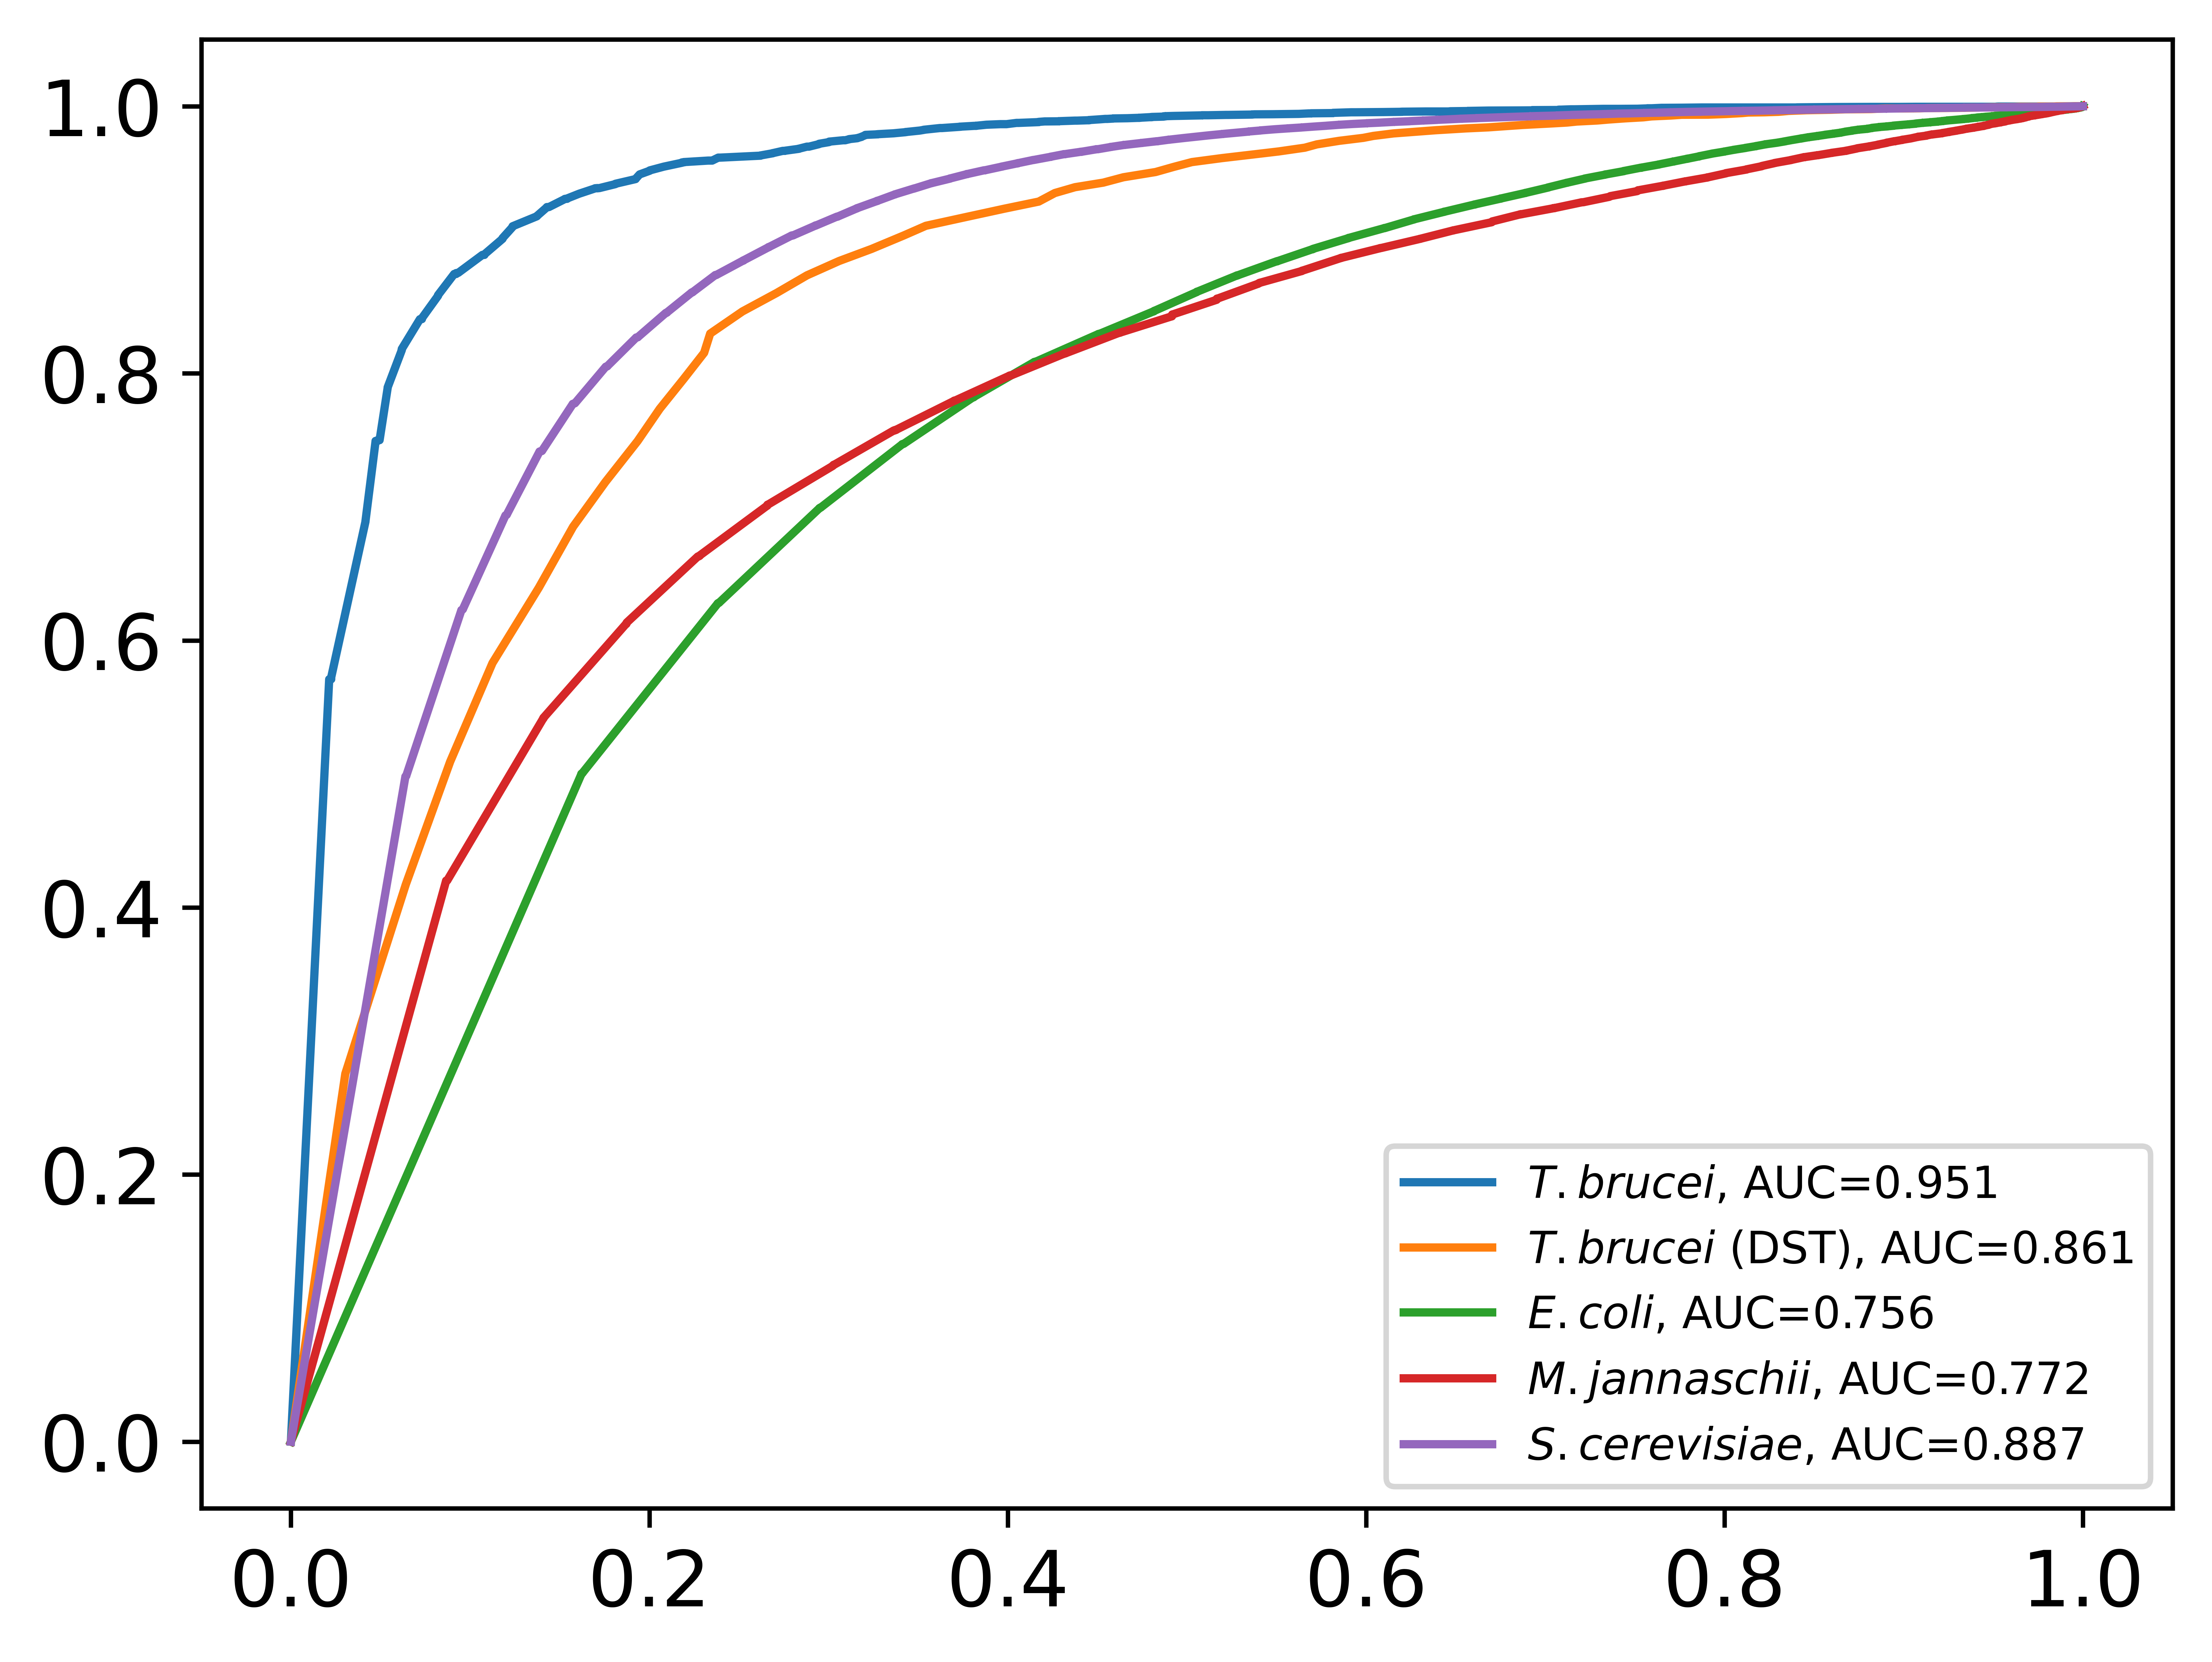

In [20]:
plt.figure(0).clf()
plt.figure(dpi=1200)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#add legend
plt.legend()

for frac in ModelDict.keys():
    model = ModelDict[frac]
    y_pred_prob = model.predict_proba(X_test[:,:7])[:, 1]
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_prob)
    auc = round(metrics.roc_auc_score(y_test, y_pred_prob),3)
    if frac!= 1:
        plt.plot(fpr,tpr,label= "$\it{T. brucei}$ (DST)" +", AUC="+str(auc))
    else:
        plt.plot(fpr,tpr,label= "$\it{T. brucei}$" + ", AUC="+str(auc))
   
model = ModelDict[1]
for org in X_dict_orgs.keys():
    y_pred_prob = model.predict_proba(X_dict_orgs[org][:,:7])[:, 1]
   
    fpr, tpr, _ = metrics.roc_curve(y_dict_orgs[org], y_pred_prob)
    auc = round(metrics.roc_auc_score(y_dict_orgs[org], y_pred_prob),3)
    plt.plot(fpr,tpr,label= "$\it{" + FullNameDict[org] + "}$" + ", AUC="+str(auc))

plt.legend( prop={'size': 8})